In [2]:
# import sys
# !{sys.executable} -m pip install tqdm
import os
from tqdm import tqdm
from dasquakes import *
import datetime
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt

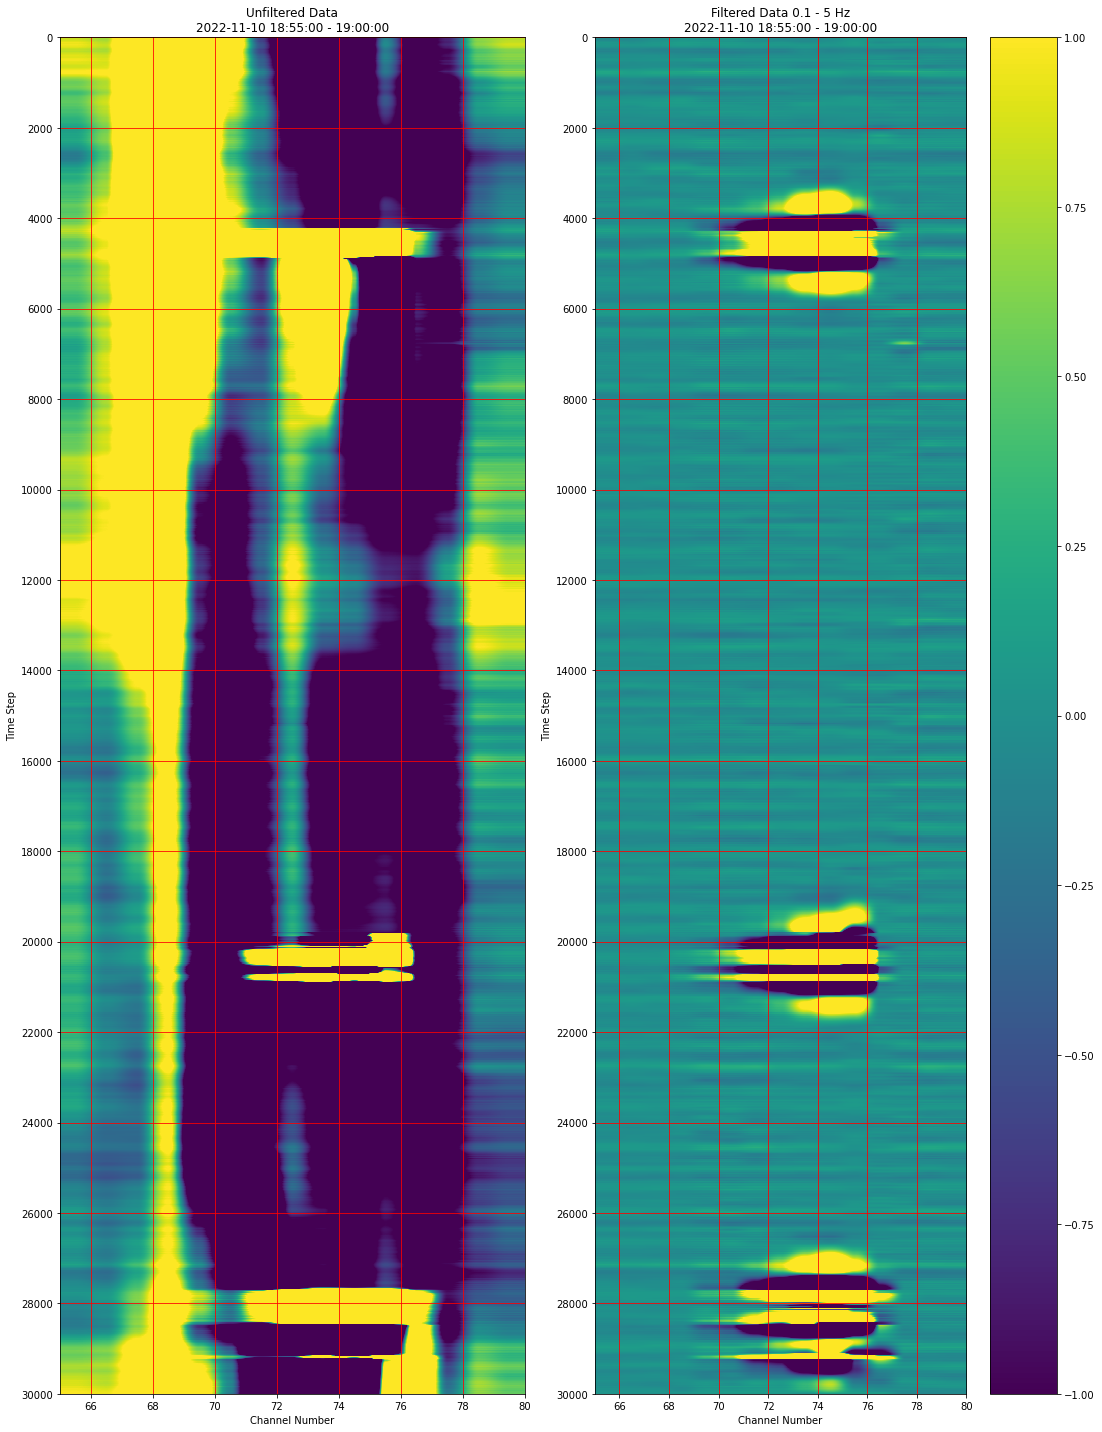

In [10]:
# cable='whidbey'
cable = 'seadasn'
record_length = 5 #minutes
y_max = record_length * 60 * 100
t0 = datetime.datetime(2022, 11, 11, 0, 16-1, 0)





# boioioing
lower_freq = .1
upper_freq = 5


# # parabola
# lower_freq = 0.047
# upper_freq = 0.095


# wompwomp
# lower_freq = 0.015
# upper_freq = 0.02

# boioioing channels
lower_chan = 65
upper_chan = 80

# # Red Square
# lower_chan = 35
# upper_chan = 130


# chasing loopy thing
# lower_chan = 85
# upper_chan = 155

# # chasing loopy thing
# lower_chan = 85
# upper_chan = 155

# # 3 am shaking
# lower_chan = 0
# upper_chan = 400


vm = 1

counter = 0
for hour in range(0, 24, 1):
    if counter == 1:
        break
    for minute in range(55, 60, record_length):
        t0 = datetime.datetime(2022, 11, 11, 2 + hour, minute, 0)



        prefix, network_name, datastore = data_wrangler(cable, record_length, t0)

        data, dates, attrs = open_sintela_file(
             prefix,
             t0,
             datastore,
             number_of_files=record_length,
             verbose=False
        )

        nt = data.shape[0]
        nx = data.shape[1]
        #         print(f'Number of time steps: {nt}, Number of channels: {nx}')

        #         print(
        #             (f"Nyquist Frequency: {attrs['MaximumFrequency']} Hz, ") +
        #             (f"cable length: {attrs['SpatialSamplingInterval']*nx} m")
        #         )

        data_subset = data[:, lower_chan:upper_chan]
        fs = 2 * attrs['MaximumFrequency']


        b,a = butter(2,[lower_freq, upper_freq],'bandpass',fs = fs)
        data_subset_filtered = filtfilt(b,a,data_subset,axis=0)

        searched_object = [data_subset, data_subset_filtered]
        fig = plt.figure(figsize = (15,20))
        for n, ob in enumerate(searched_object):


            ax = plt.subplot(1, 2, n + 1)
            c = ax.imshow(
                ob,
                aspect = 'auto',
                vmin = -vm,
                vmax = vm,
                extent = (lower_chan, upper_chan, y_max, 0)
            )
            plt.xlabel('Channel Number')
            plt.ylabel('Time Step')
            fig.patch.set_facecolor('w')
            time_change = datetime.timedelta(hours = -8)
            minute_change = datetime.timedelta(minutes = record_length)

            new_time = t0 + time_change
            time_end = t0 + time_change + minute_change

            if n == 0:
                ax.set_title(
                    'Unfiltered Data\n' + 
                    str(new_time) +
                    ' - ' + 
                    str(time_end.time())
                )

            if n == 1:
                ax.set_title(
                    'Filtered Data ' + str(lower_freq) + ' - ' + 
                    str(upper_freq) + ' Hz\n' +
                    str(new_time) +
                    ' - ' + 
                    str(time_end.time())            
                )

            plt.locator_params(axis='y', nbins=15)
            plt.grid(color = 'red', which = 'both')
#             ax.yaxis.get_ticklocs(minor=True)
#             ax.xaxis.get_ticklocs(minor=True)
#             ax.minorticks_on()

        plt.tight_layout()
        plt.colorbar(c)
        plt.show()
        counter = counter + 1

#         break
#     break

In [ ]:
# for n in range(15, 19, 1):
#     if n < 10:
#         date = f'11-11_02-0{n}-00'
        
#     if n >= 10:
#         date = f'11-11_02-{n}-00'
# # date = '11-10_02-18'
#     for file in ((os.listdir(data_dir))):
#         if date in file:
#             print(file[13:27])
#             data_file = data_dir + file
#             data = h5py.File(data_file,'r')
#             phi = np.array(data['Acquisition/Raw[0]/RawData'])
#             fig, axes = plt.subplots(4, 1, figsize=(10,10))
#             for n, freq in enumerate(searched_object):
#                 print(n, freq)
#                 [b,a] = butter(
#                     2,
#                     freq, 
#                     'bandpass', 
#                     fs = 3500
#                 )


#                 phi_filt = filtfilt(b, a, phi, axis=0)

#     #                 vm = 0.0001
#                 if n == 0:
#                     vm = 1
#                 if n == 1:
#                     vm = 0.1
#                 if n == 2:
#                     vm = 0.01
#                 if n == 3:
#                     vm = 0.00001
#                 plt.subplot(4, 1, n + 1)
#                 c = plt.imshow(
#                     phi_filt,
#                     extent=[0,29.9,0,(60)],
#                     vmin = -vm,
#                     vmax = vm,
#                     aspect='auto',
# #                     origin = 'lower'
#                 )
#                 plt.colorbar(c)
#                 plt.xlabel('Optical Distance (km)')
#                 plt.ylabel('Time (s)')

#     #             # university station
#     #             plt.xlim([0.964,1.311])
#                 # university station
#                 plt.xlim([0.250,1.3])

#     #                 #full cable
#     #                 plt.xlim([0,29.9])

#     #                 # roosevelt
#                 plt.xlim([3.621,3.704])
# #                 ch 567


#                 fig.set_facecolor('w')

#             sound_list = searched_object
#             title = []
#             for n, sound in enumerate(sound_list):

#                 title1 = sound_list[n][0]
#                 title2 = sound_list[n][1]
#                 title.append([title1, title2])

#             axes[0].set_title(f'{np.round(title[0][0], 2)} - {np.round(title[0][1], 2)} Hz')
#             axes[1].set_title(f'{np.round(title[1][0], 2)} - {np.round(title[1][1], 2)} Hz')
#             axes[2].set_title(f'{np.round(title[2][0], 2)} - {np.round(title[2][1], 2)} Hz')
#             axes[3].set_title(f'{np.round(title[3][0], 2)} - {np.round(title[3][1], 2)} Hz')

#             plt.tight_layout()
#             plt.show()
#     #             break
#     #         break
#     #     break
#         #             phi_filt = filtfilt(b, a, phi, axis=0)
#     #     #         fig, ax = plt.subplots(figsize=(10,5))
#     #             vm = 0.01
#     #             plt.subplot(2, 1, 2)
#     #             c = plt.imshow(
#     #                 phi_filt,
#     #                 extent=[0,29.9,0,60],
#     #                 vmin = -vm,
#     #                 vmax = vm,
#     #                 aspect='auto'
#     #             )
#     #             plt.colorbar(c)
#     #             plt.xlabel('Optical Distance (km)')
#     #             plt.ylabel('Time (s)')
#     #             plt.xlim([0.960,1.321])
#     # #             plt.xlim([0, 29.9])
#     # #             plt.xlim([2.364,3.468])
#     #             fig.set_facecolor('w')
#     #             plt.tight_layout()
#     #             plt.show()



In [ ]:
# file = 'seadasn_2022-10-05_08-56-00_UTC_038572.h5'
# data_file = data_dir + file
# data_file

In [ ]:
# data = h5py.File(data_file,'r')

In [ ]:
# phi = np.array(data['Acquisition/Raw[0]/RawData'])

In [ ]:
# [b,a] = butter(2, 10/50, 'high')
# [b,a] = butter(2, 10/50, 'high')


# phi_filt = filtfilt(b, a, phi, axis=0)

In [ ]:
# fig, ax = plt.subplots(figsize=(10,5))
# vm = 0.01
# c = plt.imshow(
#     phi_filt,
#     extent=[0,29.9,0,60],
#     vmin = -vm,
#     vmax = vm,
#     aspect='auto'
# )
# plt.colorbar(c)
# plt.xlabel('Optical Distance (km)')
# plt.ylabel('Time (s)')
# plt.xlim([0.999,1.292])
# fig.set_facecolor('w')
# plt.show()